In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [121]:
import scipy as sp
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [122]:
df = pd.read_csv("data/rsbuddy/buy_average.csv")
df = df.set_index('timestamp')
df2 = pd.read_csv("data/rsbuddy/sell_average.csv")
df2 = df2.set_index('timestamp')

In [123]:
dropped = df.drop_duplicates()
dropped2 = df2.drop_duplicates()
runes = dropped[['Chaos_rune', 'Nature_rune', 'Soul_rune', 'Blood_rune', 'Law_rune']]
runes2 = dropped2[['Chaos_rune', 'Nature_rune', 'Soul_rune', 'Blood_rune', 'Law_rune']]
# y = runes.reset_index()['Chaos_rune']

In [124]:
print(runes.shape)
print(runes2.shape)
runes.head()

(1086, 5)
(1086, 5)


,Chaos_rune,Nature_rune,Soul_rune,Blood_rune,Law_rune
timestamp,,,,,
1577227800,66,218,146,305,142
1577229600,66,219,147,304,142
1577231400,66,218,146,304,142
1577233501,66,218,145,304,140
1577235300,66,218,144,301,140


In [99]:
# stacked = pd.melt(df.reset_index(), id_vars=['timestamp'], value_vars=['Chaos_rune', 'Nature_rune', 'Soul_rune', 'Blood_rune', 'Law_rune'], var_name='var_name', value_name='value')
# print(stacked.head())

    timestamp    var_name  value
0  1577227800  Chaos_rune     66
1  1577229600  Chaos_rune     66
2  1577231400  Chaos_rune     66
3  1577233501  Chaos_rune     66
4  1577235300  Chaos_rune     66


In [125]:
# extracted_features = extract_features(stacked, column_id="var_name", column_sort="timestamp")
# impute(extracted_features)

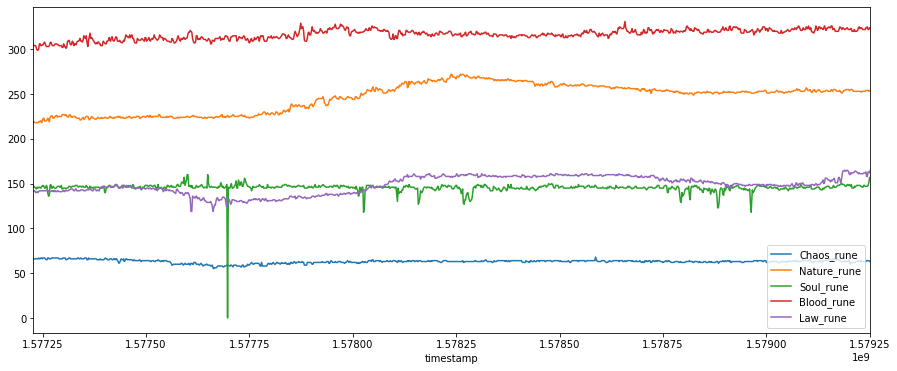

In [129]:
runes.plot(figsize=(15, 6))
plt.show()

In [130]:
df_shift, y = make_forecasting_frame(runes["Chaos_rune"], kind="buy_average", max_timeshift=20, rolling_direction=1)

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\tsfresh\utilities\dataframe_functions.py:460: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


In [131]:
df_shift.head()

,time,value,id,kind
20425,1.577228e+09,66.0,1577229600,buy_average
19341,1.577228e+09,66.0,1577231400,buy_average
20426,1.577230e+09,66.0,1577231400,buy_average
18258,1.577228e+09,66.0,1577233501,buy_average
19342,1.577230e+09,66.0,1577233501,buy_average


In [132]:
df_shift.shape

(21510, 4)

In [133]:
%%capture
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, show_warnings=False)

In [134]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

(1085, 754)
(1085, 344)


In [135]:
# Add last value as feature
X["feature_last_value"] = y.shift(1)

In [136]:
# Drop first line
X = X.iloc[1:, ]
y = y.iloc[1: ]

In [137]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""",...,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation,feature_last_value
id,,,,,,,,,,,,,,,,,,,,,
1577231400,8712.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,63.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0
1577233501,13068.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,63.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0
1577235300,17424.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,63.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0
1577237100,21780.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,63.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0
1577238900,26136.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,66.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0


In [139]:

from tqdm import tqdm

In [ ]:
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

isp = 100   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)


  8%|█████████████▎                                                                                                                                                              | 76/984 [00:04<01:08, 13.16it/s]


 15%|██████████████████████████▍                                                                                                                                                | 152/984 [00:11<01:22, 10.07it/s]


 20%|█████████████████████████████████▎                                                                                                                                         | 192/984 [00:16<01:34,  8.40it/s]


 23%|███████████████████████████████████████▉                                                                                                                                   | 230/984 [00:21<01:42,  7.34it/s]


 27%|██████████████████████████████████████████████▌                                                                                                                            | 268/984 [00:26<01:44,  6.84it/s]


 31%|█████████████████████████████████████████████████████▏                                                                                                                     | 306/984 [00:32<01:50,  6.14it/s]


 35%|███████████████████████████████████████████████████████████▊                                                                                                               | 344/984 [00:38<01:51,  5.76it/s]


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                        | 382/984 [00:45<01:52,  5.33it/s]


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                                  | 420/984 [00:53<01:54,  4.94it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                           | 458/984 [01:01<01:53,  4.62it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 496/984 [01:09<01:52,  4.35it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 534/984 [01:20<02:31,  2.96it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 546/984 [01:24<02:30,  2.92it/s]

In [ ]:

# Dataframe of predictions and true values
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})

# Convert index to a datetime
ys.index = pd.to_datetime(ys.index)
ys.head()

In [ ]:
ys.plot(figsize=(15, 8))
plt.title('Predicted and True Price')
plt.show()

In [ ]:
# Create column of previous price
ys['y-1'] = ys['true'].shift(1)
ys[['y-1', 'true']].plot(figsize = (15, 8))
plt.title('Benchmark Prediction and True Price')
plt.show()

In [ ]:
print("MAE y-1: \t{}".format(np.mean(np.abs(np.diff(y))[isp-1:] )))
print("MAE ada: \t{}".format(np.mean(np.abs(y_pred - y)[isp:])))

In [ ]:
importances = pd.Series(index=X.columns, data=ada.feature_importances_)
importances.sort_values(ascending=False).head(10)